<a href="https://colab.research.google.com/github/danaabdi/Datathon2025/blob/main/Datathon_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EXPLORATORY DATA ANALYSIS**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler


In [ ]:
# Step 1: Read the Excel file
file_path = '/content/cleaned-modecraft-data.xlsx'  # replace this with your actual file name
data = pd.read_excel(file_path)


In [ ]:
# See structure (columns, types, non-null counts)
print(data.info())

# Quick statistics on numeric columns
print(data.describe())

# Count missing values
print(data.isnull().sum())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
1    536365     21730    GLASS STAR FROSTED T-LIGHT HOLDER         6   
2    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
3    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
4    536365     22752         SET 7 BABUSHKA NESTING BOXES         2   

          InvoiceDate  UnitPrice  CustomerID         Country  \
0 2010-12-01 08:26:00       2.75     17850.0  United Kingdom   
1 2010-12-01 08:26:00       4.25     17850.0  United Kingdom   
2 2010-12-01 08:26:00       3.39     17850.0  United Kingdom   
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom   
4 2010-12-01 08:26:00       7.65     17850.0  United Kingdom   

   Revenue (pounds) Day of Week Time of Day Weekday or Weekend Quarter  
0             22.00   Wednesday     Morning            Weekday      Q4  
1             25.50   Wednesday     

In [ ]:
data.shape
print(data.columns.tolist())


['InvoiceNo', 'StockCode', 'Product Name', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country', 'Revenue (pounds)', 'Day of Week', 'Time of Day', 'Weekday or Weekend', 'Quarter', 'Month', 'Season']


In [ ]:
# Calculate basic product KPIs
product_kpis = data.groupby('Product Name').agg({
    'Quantity': 'sum',
    'UnitPrice': 'mean',
    'InvoiceNo': 'nunique'
}).reset_index()


# Calculate basic product KPIs
product_revenue = data.groupby('Product Name')['Revenue (pounds)'].sum().reset_index()

# Merge KPIs with Revenue
product_kpis = pd.merge(product_kpis, product_revenue, on='Product Name')
print(product_kpis)

                      Product Name  Quantity  UnitPrice  InvoiceNo  \
0            *Boombox Ipod Classic         1  16.980000          1   
1          *USB Office Mirror Ball         2   8.470000          2   
2           10 COLOUR SPACEBOY PEN      6564   1.055956        318   
3       12 COLOURED PARTY BALLOONS      2155   0.703314        163   
4        12 DAISY PEGS IN WOOD BOX       349   1.907143         77   
...                            ...       ...        ...        ...   
4061           wrongly coded 20713       800   0.000000          1   
4062           wrongly coded 23343      1000   0.000000          1   
4063                wrongly marked        48   0.000000          1   
4064          wrongly marked 23343       200   0.000000          1   
4065  wrongly sold (22719) barcode       170   0.000000          1   

      Revenue (pounds)  
0                16.98  
1                16.94  
2              5585.45  
3              1412.16  
4               600.87  
...      

In [ ]:
# Rename columns for clarity
product_kpis.rename(columns={
    'Quantity': 'Total Quantity',
    'UnitPrice': 'Avg UnitPrice',
    'InvoiceNo': 'Invoice Count',
    'Revenue (pounds)': 'Total Revenue'
}, inplace=True)

# Normalize the important columns
scaler = MinMaxScaler()
product_kpis[['Revenue_Score', 'Quantity_Score', 'Invoice_Score']] = scaler.fit_transform(
    product_kpis[['Total Revenue', 'Total Quantity', 'Invoice Count']]
)

# Create the Product Health Score
product_kpis['Product Health Score'] = (
    0.5 * product_kpis['Revenue_Score'] +
    0.3 * product_kpis['Quantity_Score'] +
    0.2 * product_kpis['Invoice_Score']
)

# Rank products by the Health Score
product_kpis['Product Rank'] = product_kpis['Product Health Score'].rank(ascending=False, method='first')

# Sort by rank
product_kpis = product_kpis.sort_values('Product Rank')

# Show final ranked products
print(product_kpis[['Product Rank', 'Product Name', 'Product Health Score', 'Total Revenue', 'Total Quantity', 'Invoice Count']].head(20))

      Product Rank                        Product Name  Product Health Score  \
2392           1.0         PAPER CRAFT , LITTLE BIRDIE              0.713076   
2856           2.0            REGENCY CAKESTAND 3 TIER              0.654367   
3850           3.0  WHITE HANGING HEART T-LIGHT HOLDER              0.610375   
1816           4.0             JUMBO BAG RED RETROSPOT              0.607199   
1061           5.0                      DOTCOM POSTAGE              0.565213   
2054           6.0      MEDIUM CERAMIC TOP STORAGE JAR              0.524242   
2417           7.0                       PARTY BUNTING              0.471353   
219            8.0       ASSORTED COLOUR BIRD ORNAMENT              0.425197   
2743           9.0                  RABBIT NIGHT LIGHT              0.381478   
2386          10.0      PAPER CHAIN KIT 50'S CHRISTMAS              0.349196   
2342          11.0     PACK OF 72 RETROSPOT CAKE CASES              0.326035   
2004          12.0             LUNCH BAG

Quantity Model MAE: 4.742163181304932
Revenue Model MAE: 9.267872070312524


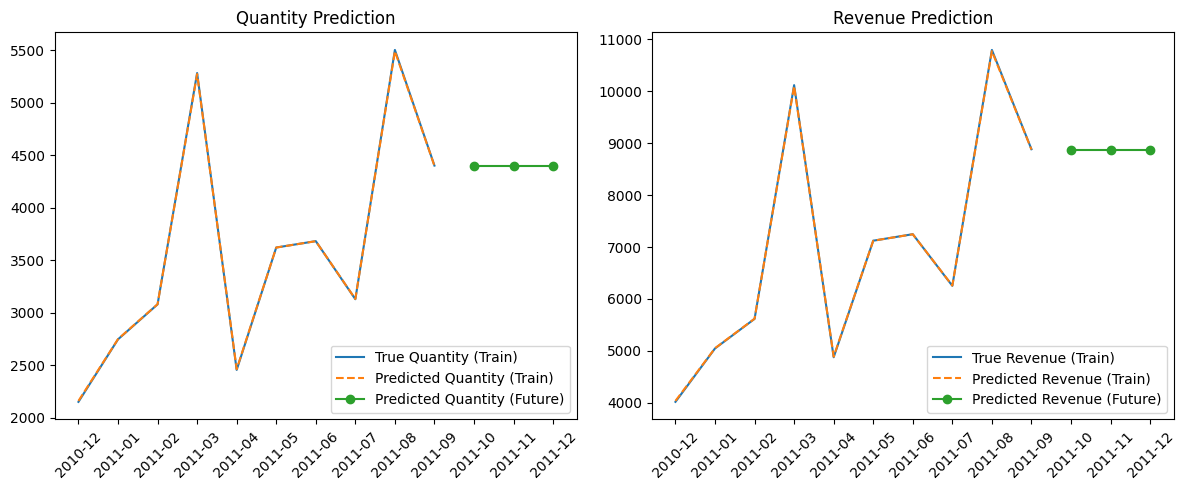


 Future 3-Month Predictions for StockCode: 85099B
     Month  Predicted Quantity  Predicted Revenue
0  2011-10          4398.27002        8878.259766
1  2011-11          4398.27002        8878.259766
2  2011-12          4398.27002        8878.259766


In [ ]:
# Step 0: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor


# Step 2: Basic Cleaning
data.columns = data.columns.str.strip()  # clean column names
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Create Revenue
data['Revenue'] = data['Quantity'] * data['UnitPrice']

# Step 3: Feature Engineering
data['Month'] = data['InvoiceDate'].dt.to_period('M')

# Step 4: Aggregate to Monthly Data per Product
monthly_product_data = data.groupby(['StockCode', 'Month']).agg({
    'Quantity': 'sum',
    'Revenue': 'sum'
}).reset_index()

# Step 5: Select Specific StockCode
selected_stockcode = '85099B'  # Change this to the product you want
product_data = monthly_product_data[monthly_product_data['StockCode'] == selected_stockcode].copy()

# Convert Month to numeric for modeling
product_data['Month_Num'] = product_data['Month'].apply(lambda x: x.ordinal)

# Step 6: Prepare Features (X) and Targets (y)
X = product_data[['Month_Num']]  # Feature
y_quantity = product_data['Quantity']  # Target 1
y_revenue = product_data['Revenue']    # Target 2

# Step 7: Split Train and Future Data
# Assume last 3 months are "future" we want to predict
X_train = X.iloc[:-3]
X_future = X.iloc[-3:]

y_quantity_train = y_quantity.iloc[:-3]
y_quantity_future = y_quantity.iloc[-3:]

y_revenue_train = y_revenue.iloc[:-3]
y_revenue_future = y_revenue.iloc[-3:]

# Step 8: Train XGBoost Models

# For Quantity
quantity_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
quantity_model.fit(X_train, y_quantity_train)

# For Revenue
revenue_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
revenue_model.fit(X_train, y_revenue_train)

# Step 9: Make Predictions
quantity_pred = quantity_model.predict(X_future)
revenue_pred = revenue_model.predict(X_future)

# Step 10: Evaluate Models
quantity_train_pred = quantity_model.predict(X_train)
revenue_train_pred = revenue_model.predict(X_train)

print("Quantity Model MAE:", mean_absolute_error(y_quantity_train, quantity_train_pred))
print("Revenue Model MAE:", mean_absolute_error(y_revenue_train, revenue_train_pred))

# Step 11: Visualize Predictions
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(product_data['Month'].iloc[:-3].astype(str), y_quantity_train, label='True Quantity (Train)')
plt.plot(product_data['Month'].iloc[:-3].astype(str), quantity_train_pred, label='Predicted Quantity (Train)', linestyle='--')
plt.plot(product_data['Month'].iloc[-3:].astype(str), quantity_pred, label='Predicted Quantity (Future)', marker='o')
plt.title('Quantity Prediction')
plt.xticks(rotation=45)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(product_data['Month'].iloc[:-3].astype(str), y_revenue_train, label='True Revenue (Train)')
plt.plot(product_data['Month'].iloc[:-3].astype(str), revenue_train_pred, label='Predicted Revenue (Train)', linestyle='--')
plt.plot(product_data['Month'].iloc[-3:].astype(str), revenue_pred, label='Predicted Revenue (Future)', marker='o')
plt.title('Revenue Prediction')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

# Step 12: Output future predictions
future_months = product_data['Month'].iloc[-3:].astype(str).values

output = pd.DataFrame({
    'Month': future_months,
    'Predicted Quantity': quantity_pred.round(2),
    'Predicted Revenue': revenue_pred.round(2)
})

print("\n Future 3-Month Predictions for StockCode:", selected_stockcode)
print(output)

In [ ]:
# 📦 Step 1: Aggregate Store-wide Revenue Monthly
store_monthly_revenue = data.groupby(data['InvoiceDate'].dt.to_period('M')).agg({
    'Revenue': 'sum'
}).reset_index()

# Convert Month to numeric
store_monthly_revenue['Month_Num'] = store_monthly_revenue['InvoiceDate'].apply(lambda x: x.ordinal)

# 📈 Step 2: Prepare X and y
X_store = store_monthly_revenue[['Month_Num']]
y_store_revenue = store_monthly_revenue['Revenue']

# 📆 Step 3: Train/Test Split
X_train_store = X_store.iloc[:-3]
X_future_store = X_store.iloc[-3:]

y_train_store = y_store_revenue.iloc[:-3]
y_future_store = y_store_revenue.iloc[-3:]

# ⚙️ Step 4: Train Model
store_revenue_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
store_revenue_model.fit(X_train_store, y_train_store)

# 🔮 Step 5: Predict
store_revenue_pred = store_revenue_model.predict(X_future_store)

# 📋 Step 6: Output
future_months_store = store_monthly_revenue['InvoiceDate'].iloc[-3:].astype(str).values

store_output = pd.DataFrame({
    'Month': future_months_store,
    'Predicted Store Revenue': store_revenue_pred.round(2)
})

print("\n🔮 Future 3-Month Predictions for Entire Store Revenue:")
print(store_output)



🔮 Future 3-Month Predictions for Entire Store Revenue:
     Month  Predicted Store Revenue
0  2011-10                1056669.0
1  2011-11                1056669.0
2  2011-12                1056669.0


In [ ]:
# 🌍 Step 1: Choose the Country
selected_country = 'United Kingdom'  # Example, change to any country you want

# Step 2: Aggregate Revenue per Month for this Country
country_data = data[data['Country'] == selected_country]

country_monthly_revenue = country_data.groupby(country_data['InvoiceDate'].dt.to_period('M')).agg({
    'Revenue': 'sum'
}).reset_index()

# Convert Month to numeric
country_monthly_revenue['Month_Num'] = country_monthly_revenue['InvoiceDate'].apply(lambda x: x.ordinal)

# Step 3: Prepare X and y
X_country = country_monthly_revenue[['Month_Num']]
y_country_revenue = country_monthly_revenue['Revenue']

# Step 4: Train/Test Split
X_train_country = X_country.iloc[:-3]
X_future_country = X_country.iloc[-3:]

y_train_country = y_country_revenue.iloc[:-3]
y_future_country = y_country_revenue.iloc[-3:]

# Step 5: Train Model
country_revenue_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
country_revenue_model.fit(X_train_country, y_train_country)

# Step 6: Predict
country_revenue_pred = country_revenue_model.predict(X_future_country)

# 📋 Step 7: Output
future_months_country = country_monthly_revenue['InvoiceDate'].iloc[-3:].astype(str).values

country_output = pd.DataFrame({
    'Month': future_months_country,
    f'Predicted Revenue ({selected_country})': country_revenue_pred.round(2)
})

print(f"\n🔮 Future 3-Month Predictions for Revenue in {selected_country}:")
print(country_output)



🔮 Future 3-Month Predictions for Revenue in United Kingdom:
     Month  Predicted Revenue (United Kingdom)
0  2011-10                         895404.1875
1  2011-11                         895404.1875
2  2011-12                         895404.1875
